In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dataset.AI4CodeProblemClassificationDataset import AI4CodeProblemClassificationDataset
dataset = AI4CodeProblemClassificationDataset(r"C:\Users\sebas\Documents\Masterarbeit\datasets\2_parallel_dataset\ai4code_problem_class_py", 
r"C:\Users\sebas\Documents\Masterarbeit\datasets\2_parallel_dataset\ai4code_py", 228, 32, 66)

In [3]:
dataset.create()

In [4]:
from keras.metrics import Precision, Recall
import tensorflow as tf
from classifier.Tbcnn import Tbcnn
labels = dataset.get_labels()
node_map = dataset.get_vocabulary_map()
model = Tbcnn(feature_size=len(node_map), num_kernels=600, num_classes=len(labels))
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(),
              metrics = [tf.keras.metrics.CategoricalAccuracy(), Precision(), Recall()])

In [5]:
from generators.FileStreamDataGenerator import FileStreamDataGenerator

train_files = dataset.get_train_files()
val_files = dataset.get_val_files()

training_generator = FileStreamDataGenerator(train_files, labels, node_map=node_map, batch_size=32, shuffle=True)
validation_generator = FileStreamDataGenerator(val_files, labels, node_map=node_map, batch_size=32, shuffle=False)
history = model.fit(training_generator, validation_data=validation_generator, epochs=20)

Epoch 1/20
741/741 [==============================] - 87s 115ms/step - loss: 2.3836 - categorical_accuracy: 0.5261 - precision: 0.9619 - recall: 0.2107 - val_loss: 0.8665 - val_categorical_accuracy: 0.8005 - val_precision: 0.9512 - val_recall: 0.6265
Epoch 2/20
741/741 [==============================] - 78s 105ms/step - loss: 0.5935 - categorical_accuracy: 0.8601 - precision: 0.9534 - recall: 0.7543 - val_loss: 0.5061 - val_categorical_accuracy: 0.8690 - val_precision: 0.9512 - val_recall: 0.8017
Epoch 3/20
741/741 [==============================] - 74s 100ms/step - loss: 0.3695 - categorical_accuracy: 0.9073 - precision: 0.9595 - recall: 0.8588 - val_loss: 0.3949 - val_categorical_accuracy: 0.8957 - val_precision: 0.9476 - val_recall: 0.8531
Epoch 4/20
741/741 [==============================] - 75s 101ms/step - loss: 0.2708 - categorical_accuracy: 0.9318 - precision: 0.9661 - recall: 0.8980 - val_loss: 0.3443 - val_categorical_accuracy: 0.9114 - val_precision: 0.9535 - val_recall: 0.8

In [16]:
model.save("./py-model-final")
#model = tf.keras.models.load_model("./py-model-final")

INFO:tensorflow:Assets written to: ./py-model-final\assets


In [19]:
model = tf.keras.models.load_model("./py-model-final")

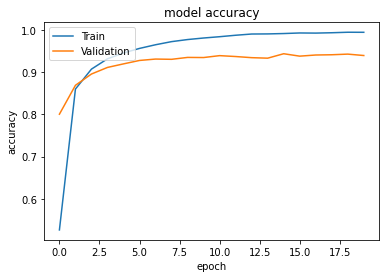

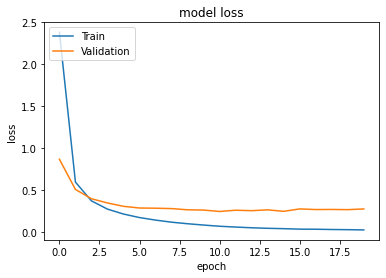

In [6]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [7]:
test_files = dataset.get_test_files()
test_generator = FileStreamDataGenerator(test_files, labels, node_map=node_map, batch_size=1, shuffle=False)
y_hat = model.predict(test_generator)
metrics = model.evaluate(test_generator)

6864/6864 [==============================] - 44s 6ms/step - loss: 0.2756 - categorical_accuracy: 0.9372 - precision: 0.9480 - recall: 0.9301


In [8]:
from numpy import argmax
labels = list(test_generator.get_label_lookup().keys())
expected_labels = []
predicted_labels = []
for i in range(len(test_generator)):
    _, y = test_generator[i]
    expected_label = labels[argmax(y)]
    predicted_label = labels[argmax(y_hat[i])]
    expected_labels.append(expected_label)
    predicted_labels.append(predicted_label)

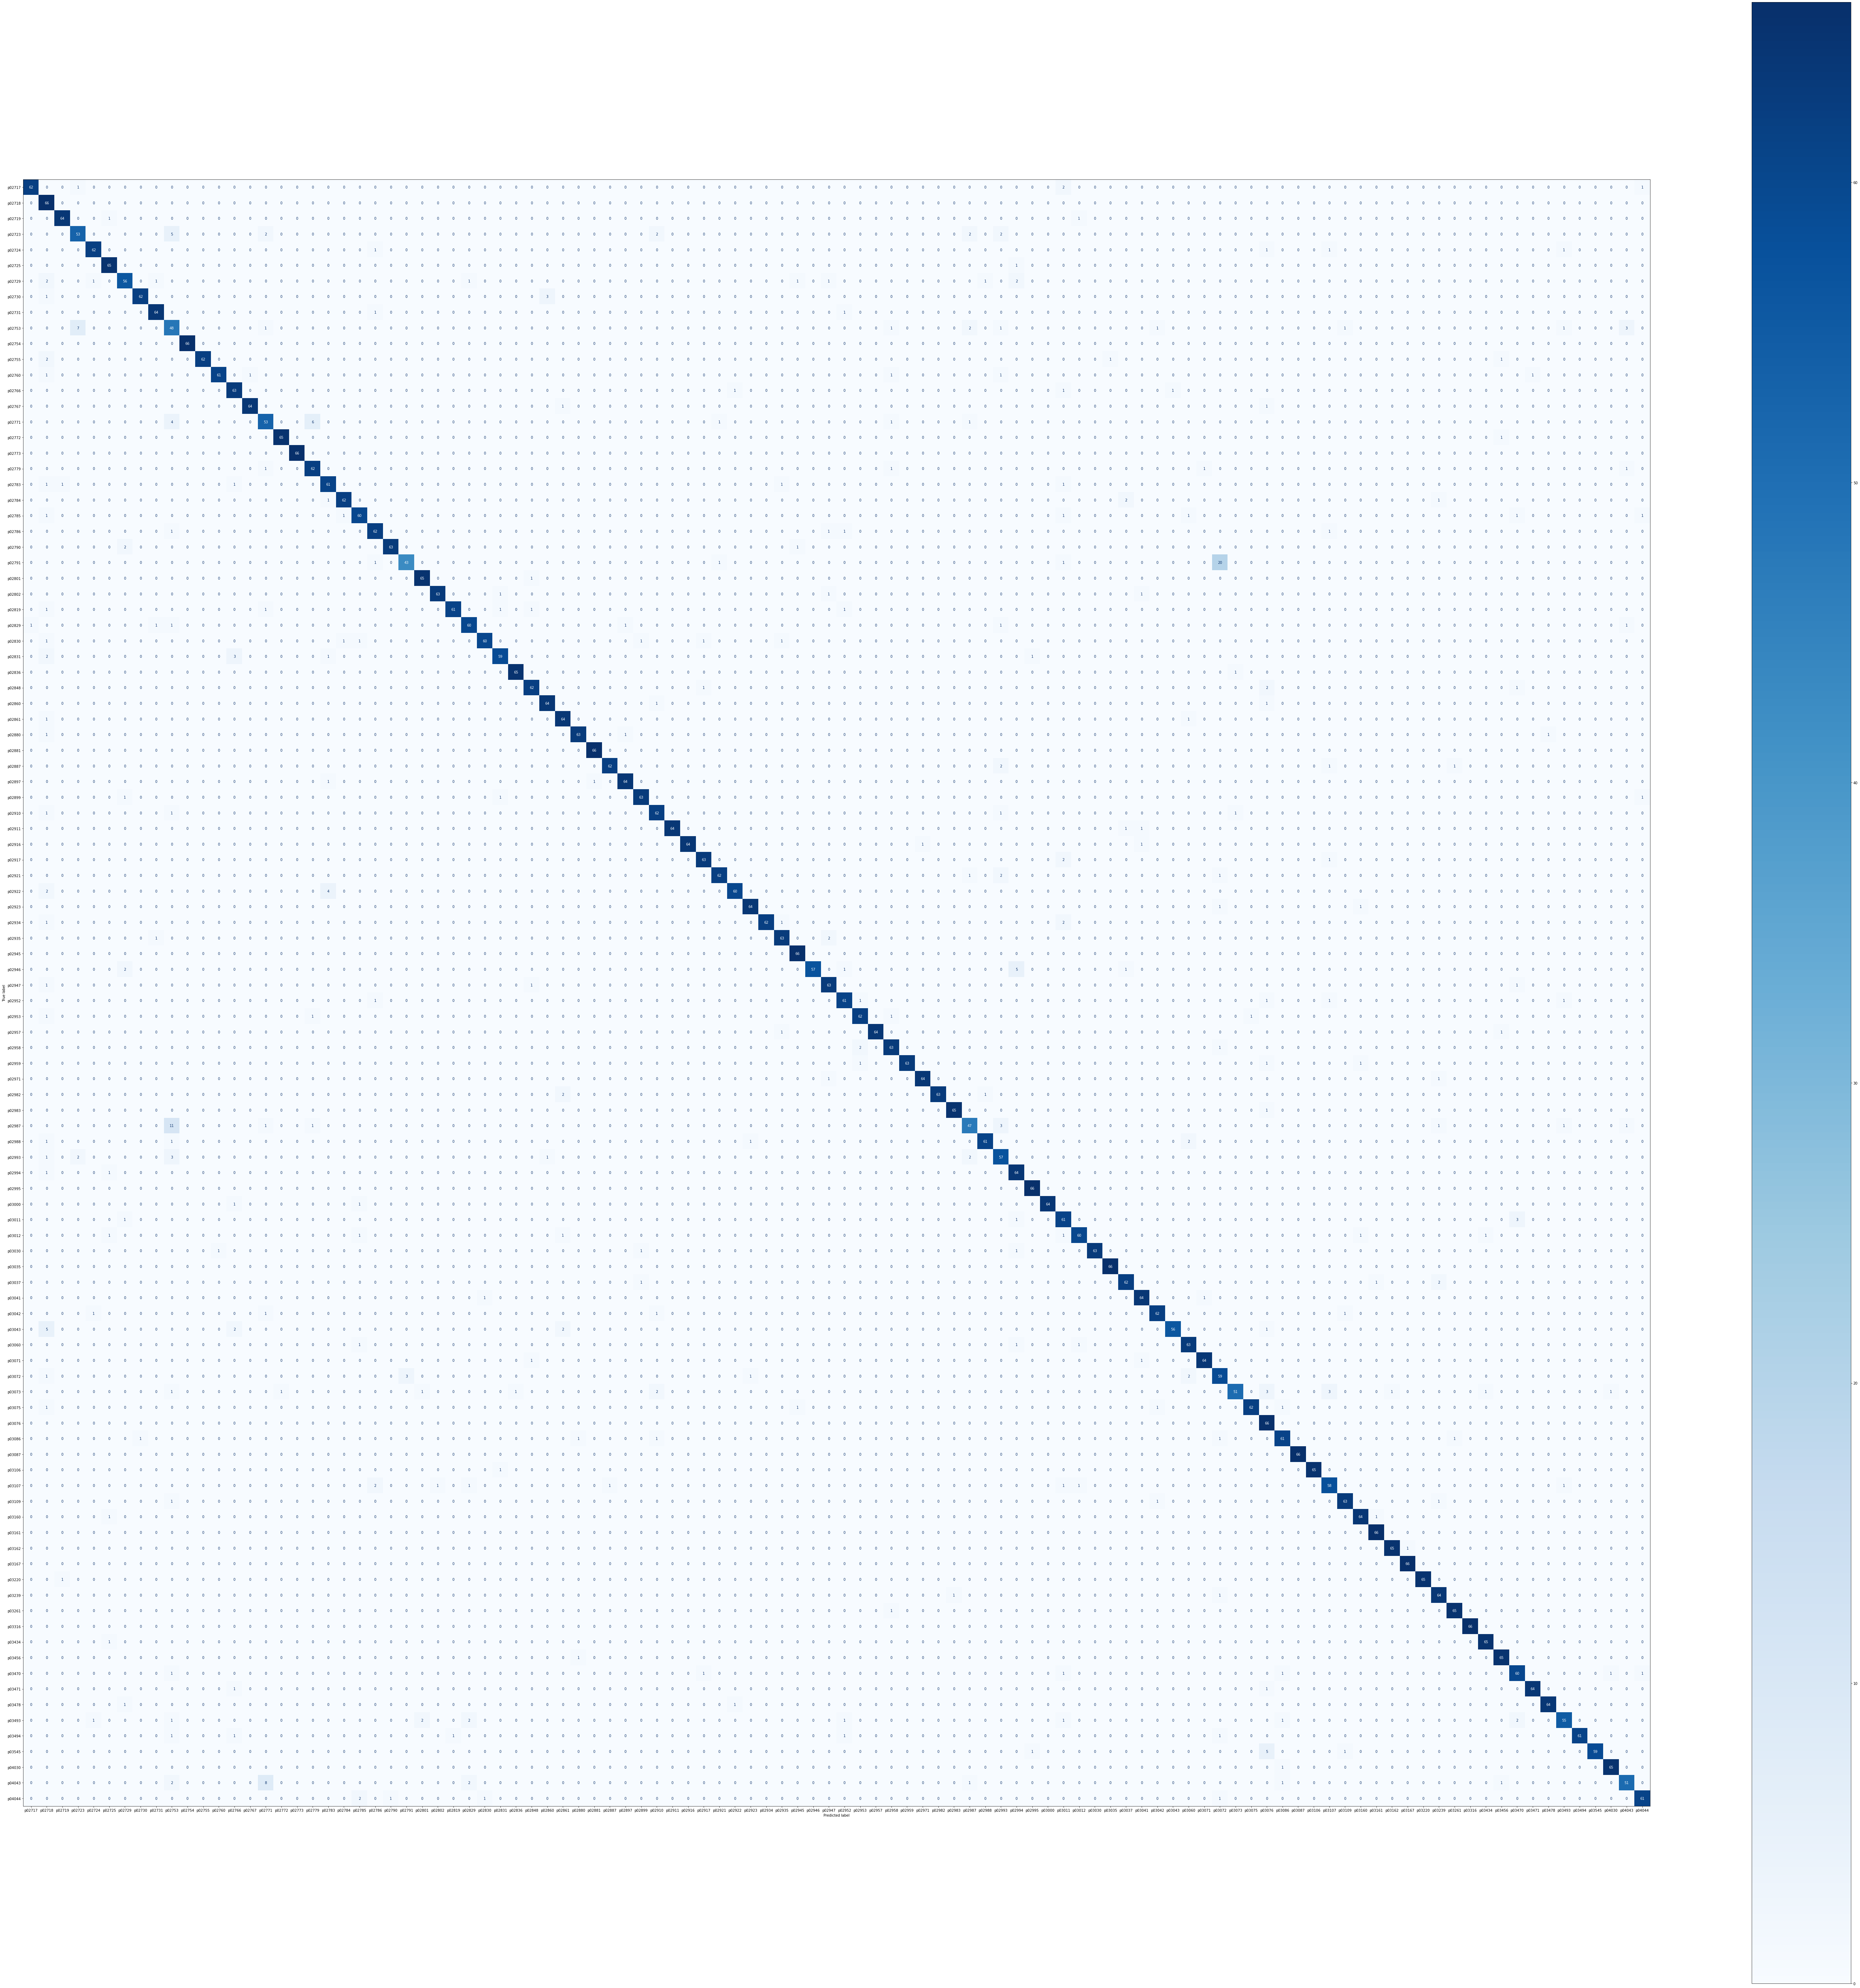

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt
_, ax = plt.subplots(1, 1, figsize=(104, 104))
cm = confusion_matrix(expected_labels, predicted_labels, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.show()

In [82]:
import numpy as np
sorted_index_array = np.argsort([3,2,3])
sorted_index_array[-2 : ]

array([0, 2], dtype=int64)

In [94]:
from numpy import argmax
labels = list(test_generator.get_label_lookup().keys())
expected_labels = []
predicted_labels = []
for i in range(len(test_generator)):
    _, y = test_generator[i]
    expected_label = labels[argmax(y)]
    predicted_label_idx = np.argsort(y_hat[i])[-2: ]
    expected_labels.append(expected_label)
    if labels[predicted_label_idx[0]] == expected_label or labels[predicted_label_idx[1]] == expected_label:
        predicted_labels.append(expected_label)
    else:
        predicted_labels.append(labels[argmax(y_hat[i])])

In [95]:
from sklearn.metrics import accuracy_score
accuracy_score(expected_labels, predicted_labels)

0.9702797202797203

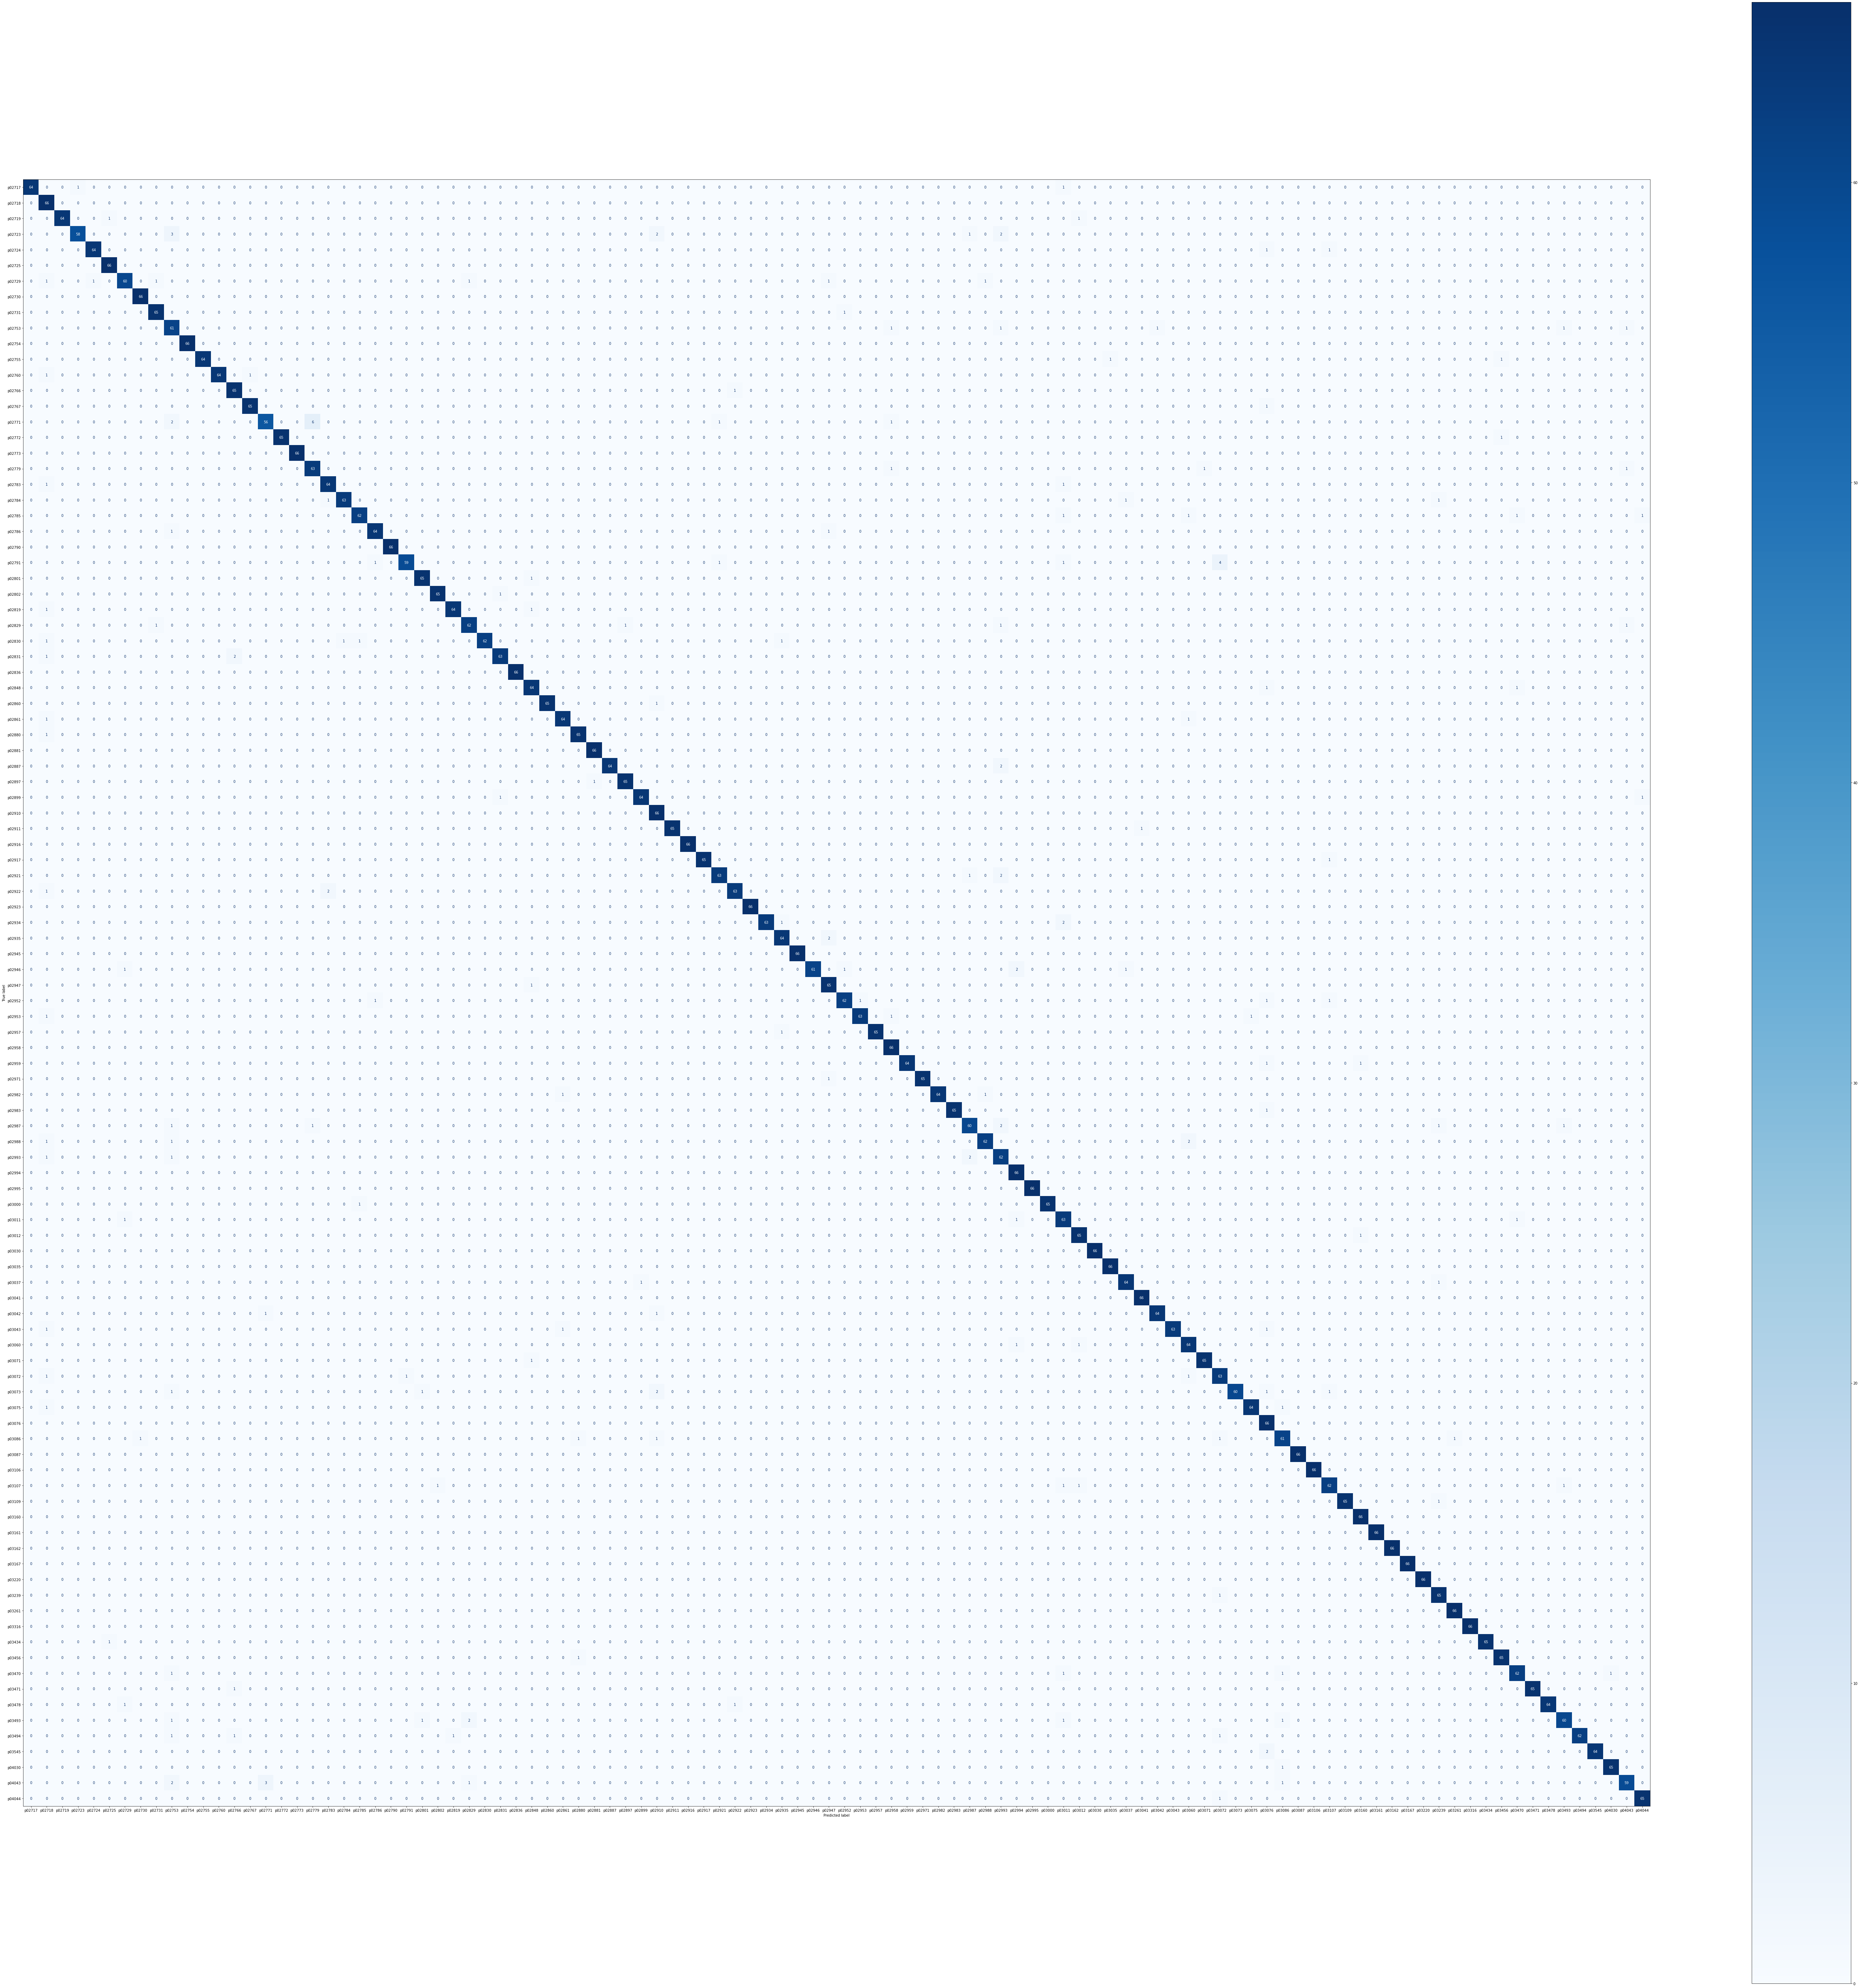

In [89]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt
_, ax = plt.subplots(1, 1, figsize=(104, 104))
cm = confusion_matrix(expected_labels, predicted_labels, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.show()

In [33]:
import io
out_v = io.open('C:\\Users\\sebas\\Documents\\Masterarbeit\\final_eval\\python\\py_test_dense_vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('C:\\Users\\sebas\\Documents\\Masterarbeit\\final_eval\\python\\py_test_dense_metadata.tsv', 'w', encoding='utf-8')

for input, label in test_generator:
    conv_filter_activations = model.conv_layer(input)
    conv_ast_embedding = model.pooling_layer(conv_filter_activations)[1]
    dense_embedding = model.hidden(conv_ast_embedding)[0]
    vec = dense_embedding.numpy().tolist()
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
    out_m.write(labels[argmax(label)] + "\n")
out_v.close()
out_m.close()

In [34]:
import io
out_v = io.open('C:\\Users\\sebas\\Documents\\Masterarbeit\\final_eval\\python\\py_test_5_vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('C:\\Users\\sebas\\Documents\\Masterarbeit\\final_eval\\python\\py_test_5_metadata.tsv', 'w', encoding='utf-8')

for input, label in test_generator:
    conv_filter_activations = model.conv_layer(input)
    conv_ast_embedding = model.pooling_layer(conv_filter_activations)[1]
    vec = conv_ast_embedding.numpy().tolist()[0]
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
    out_m.write(labels[argmax(label)] + "\n")
out_v.close()
out_m.close()

In [35]:
import io
from collections import Counter
out_v = io.open('C:\\Users\\sebas\\Documents\\Masterarbeit\\final_eval\\python\\py_test_5_vectors_ni.tsv', 'w', encoding='utf-8')
out_m = io.open('C:\\Users\\sebas\\Documents\\Masterarbeit\\final_eval\\python\\py_test_5_metadata_ni.tsv', 'w', encoding='utf-8')
node_list = list(dataset.get_vocabulary_map())
for input, label in test_generator:
    conv_filter_activations = model.conv_layer(input)
    node_importance = model.pooling_layer(conv_filter_activations)[0]
    node_importance_list = node_importance.numpy().tolist()[0]
    node_type_list = []
    nodes = input[0]
    for i in node_importance_list:
        node_type = node_list[argmax(nodes[0][i])]
        node_type_list.append(node_type)
    nt_counter = Counter(node_type_list)
    vec = []
    for nt in node_list:
        vec.append(nt_counter[nt])
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
    out_m.write(labels[argmax(label)] + "\n")
out_v.close()
out_m.close()

In [14]:
from collections import Counter
from visualization.GraphvizVisualizer import GraphvizVisualizer

In [46]:
import numpy as np
node_list = list(dataset.get_vocabulary_map())
overall_importance = {}
overall_importance["UNK"] = 0
for test_item in test_generator:
    nodes, children = test_item[0]
    conv_filter_activations = model.conv_layer([nodes, children])
    node_importance = model.pooling_layer(conv_filter_activations)[0]
    node_importance_list = node_importance.numpy().tolist()[0]
    counter = Counter(node_importance_list)
    for node_id, value in counter.items():
        one_hot_node_type = nodes[0][node_id]
        if not np.any(one_hot_node_type):
            overall_importance["UNK"] += value
            continue
        node_idx = argmax(one_hot_node_type)
        node_type = node_list[node_idx]
        if node_type in overall_importance:
            overall_importance[node_type] += value
        else:
            overall_importance[node_type] = value

In [60]:
for w in sorted(overall_importance, key=overall_importance.get, reverse=True):
    print(w, overall_importance[w])

Module 903111
BinOp 652389
Compare 405644
Call 377600
If 321789
Assign 192476
For 190874
Attribute 119188
Subscript 118086
AugAssign 106988
Tuple 89028
FunctionDef 56927
List 55495
BoolOp 51621
Name 45833
ListComp 39197
Slice 33082
While 29565
Expr 27894
UnaryOp 26153
Load 23641
comprehension 23106
IfExp 19764
Sub 14481
keyword 14242
Return 13050
Lambda 11217
GeneratorExp 10178
Mult 9747
Add 9308
Div 8932
arguments 8792
Pow 8360
Mod 7611
NotEq 7540
Store 7493
FloorDiv 6172
LtE 5319
alias 4714
Import 4629
In 4604
ImportFrom 4538
Starred 4521
And 3809
Eq 3738
GtE 3371
Dict 3211
Gt 3052
Break 2793
Lt 2711
arg 2541
Or 2344
USub 2059
Set 2001
Constant 1857
Continue 1408
Try 1367
Delete 1185
Pass 845
Not 763
ExceptHandler 627
NotIn 619
BitAnd 585
SetComp 375
Del 326
DictComp 284
RShift 230
Is 208
Yield 204
BitXor 169
LShift 158
Global 118
ClassDef 116
JoinedStr 112
Assert 105
BitOr 102
FormattedValue 33
Invert 31
Raise 25
IsNot 15
UAdd 3
UNK 1


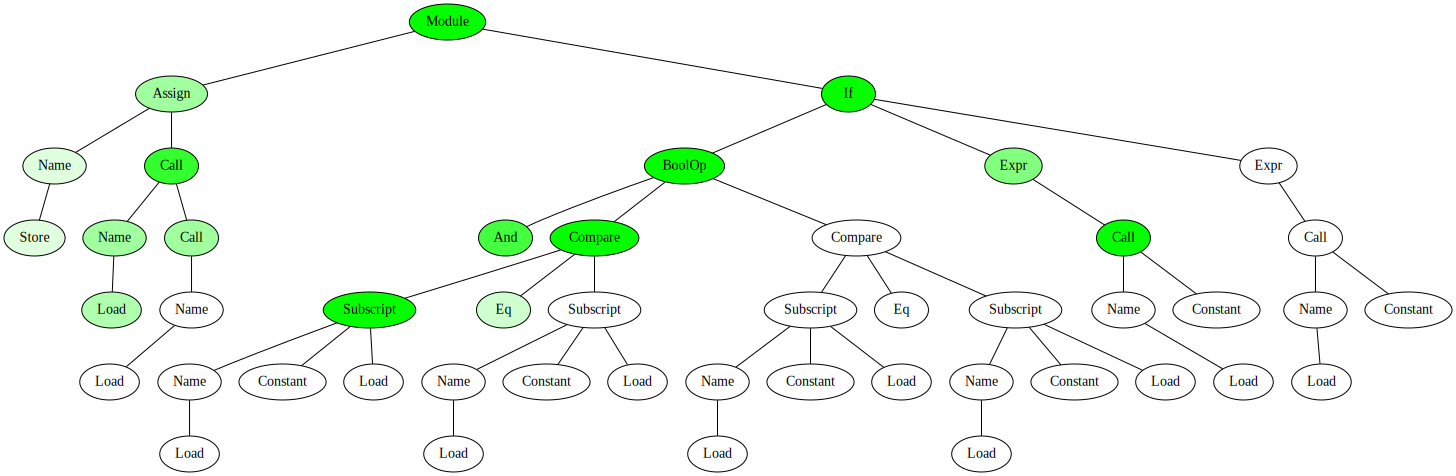

In [59]:
from visualization.GraphvizVisualizer import GraphvizVisualizer
sample_id = 1
nodes, children = test_generator.__getitem__(sample_id)[0]
conv_filter_activations = model.conv_layer([nodes, children])
node_importance = model.pooling_layer(conv_filter_activations)[0]
node_importance_list = node_importance.numpy().tolist()[0]
counter = Counter(node_importance_list)
import pickle
with open(test_files[sample_id], 'rb') as f:
    test_sample_ast = pickle.load(f)
vis = GraphvizVisualizer()
vis.visualizeAst(test_sample_ast, counter)

In [ ]:
from numpy import argmax
labels = list(test_generator.get_label_lookup().keys())
expected_labels = []
predicted_labels = []
for i in range(len(test_generator)):
    _, y = test_generator[i]
    expected_label = labels[argmax(y)]
    predicted_label = labels[argmax(y_hat[i])]
    expected_labels.append(expected_label)
    predicted_labels.append(predicted_label)

In [125]:
import numpy as np
node_list = list(dataset.get_vocabulary_map())
p03072_importance = {}
p03072_importance["UNK"] = 0
for test_item in test_generator:
    nodes, children = test_item[0]
    y = test_item[1]
    y_label = labels[argmax(y)]
    if y_label == "p02719":
        conv_filter_activations = model.conv_layer([nodes, children])
        node_importance = model.pooling_layer(conv_filter_activations)[0]
        node_importance_list = node_importance.numpy().tolist()[0]
        counter = Counter(node_importance_list)
        for node_id, value in counter.items():
            one_hot_node_type = nodes[0][node_id]
            if not np.any(one_hot_node_type):
                p03072_importance["UNK"] += value
                continue
            node_idx = argmax(one_hot_node_type)
            node_type = node_list[node_idx]
            if node_type in p03072_importance:
                p03072_importance[node_type] += value
            else:
                p03072_importance[node_type] = value

In [119]:
for w in sorted(p03072_importance, key=p03072_importance.get, reverse=True):
    print(w, p03072_importance[w])

Module 16408
Call 6386
Assign 2969
Tuple 2827
Attribute 2364
BinOp 2070
FunctionDef 916
List 818
Name 584
If 550
Subscript 522
Compare 404
Expr 384
comprehension 301
Load 267
ListComp 254
Slice 207
keyword 197
Return 188
Store 166
Lambda 139
Starred 130
arguments 106
GeneratorExp 93
alias 74
Constant 66
Import 57
Add 29
Assert 23
For 20
Eq 16
Pow 16
ImportFrom 16
Mod 15
arg 14
Sub 4
UNK 0


In [64]:
import numpy as np
node_list = list(dataset.get_vocabulary_map())
p02791_importance = {}
p02791_importance["UNK"] = 0
for test_item in test_generator:
    nodes, children = test_item[0]
    y = test_item[1]
    y_label = labels[argmax(y)]
    if y_label == "p02791":
        conv_filter_activations = model.conv_layer([nodes, children])
        node_importance = model.pooling_layer(conv_filter_activations)[0]
        node_importance_list = node_importance.numpy().tolist()[0]
        counter = Counter(node_importance_list)
        for node_id, value in counter.items():
            one_hot_node_type = nodes[0][node_id]
            if not np.any(one_hot_node_type):
                p02791_importance["UNK"] += value
                continue
            node_idx = argmax(one_hot_node_type)
            node_type = node_list[node_idx]
            if node_type in p02791_importance:
                p02791_importance[node_type] += value
            else:
                p02791_importance[node_type] = value

In [65]:
for w in sorted(p02791_importance, key=p02791_importance.get, reverse=True):
    print(w, p02791_importance[w])

Module 10125
Compare 6021
If 4514
Call 2988
For 2841
Assign 2530
BinOp 1969
AugAssign 1965
Subscript 1284
Attribute 1277
Name 439
FunctionDef 414
Expr 374
ListComp 313
Pow 221
Add 214
LtE 206
Load 205
comprehension 183
Tuple 181
List 141
GtE 140
Store 124
UnaryOp 121
Lambda 119
Return 86
Lt 63
Import 63
Pass 59
arguments 58
Continue 49
BoolOp 48
Gt 46
ImportFrom 34
alias 32
Eq 31
Slice 31
Mult 25
arg 15
Break 12
USub 10
Not 9
Sub 7
Constant 7
Or 6
UNK 0


In [126]:
difference = {}
all_keys = set(p03072_importance)
all_keys.update(set(p02791_importance))
for key in all_keys:
    importance_value = 0
    lhs_value = 0
    rhs_value = 0
    if key in p03072_importance:
        lhs_value = p03072_importance[key]
    if key in p02791_importance:
        rhs_value = p02791_importance[key]
    difference[key] = lhs_value - rhs_value

In [113]:
for w in sorted(difference, key=difference.get, reverse=True):
    print(w, difference[w])

Slice 969
Compare 875
Subscript 280
If 242
For 214
IfExp 154
ListComp 137
While 92
comprehension 76
Tuple 71
Break 62
GeneratorExp 46
List 42
Starred 40
Sub 39
UnaryOp 35
NotEq 26
Gt 20
LtE 12
Eq 8
In 6
Div 5
Mod 4
USub 4
GtE 2
FloorDiv 2
Not 1
arg 0
AugAssign 0
UNK 0
arguments -3
ImportFrom -3
Continue -4
Or -6
Constant -6
alias -11
Store -15
Load -17
Mult -18
Expr -19
Pass -26
Add -32
Lt -41
Name -41
Return -44
Import -47
BoolOp -48
Lambda -85
FunctionDef -101
Call -115
Attribute -144
Pow -221
Assign -544
Module -920
BinOp -953


In [127]:
for w in sorted(difference, key=difference.get, reverse=True):
    print(w, difference[w])

BinOp 6962
Tuple 1433
While 729
Call 637
Mod 351
Sub 313
FunctionDef 252
List 174
BoolOp 166
FloorDiv 166
Mult 115
Attribute 72
Return 71
Name 63
Load 59
Break 50
GeneratorExp 41
Global 35
UnaryOp 32
Lt 25
arguments 24
Or 23
In 21
Div 20
Gt 16
ImportFrom 14
Constant 13
arg 5
Yield 4
alias 4
USub 1
UNK 0
Not -9
Eq -10
Store -21
Lambda -23
Import -25
Slice -31
Continue -49
Pass -59
Expr -76
Assign -98
GtE -127
comprehension -133
LtE -172
Pow -175
Add -192
ListComp -244
Module -679
Subscript -1191
If -1365
AugAssign -1725
For -2632
Compare -2855
